Dataset limpio cargado: 7703 filas, 27 columnas
Etiquetas codificadas: {'APC': np.int64(0), 'CP': np.int64(1), 'FA': np.int64(2), 'FP': np.int64(3), 'KP': np.int64(4), 'PC': np.int64(5)}
Entrenamiento: 6162 | Prueba: 1541

=== XGBoost Optimizado (versión estable) ===
              precision    recall  f1-score   support

         APC       0.47      0.20      0.28        92
          CP       0.68      0.51      0.58       137
          FA       0.20      0.05      0.08        20
          FP       0.63      0.51      0.56       239
          KP       0.84      0.62      0.71       117
          PC       0.78      0.93      0.85       936

    accuracy                           0.75      1541
   macro avg       0.60      0.47      0.51      1541
weighted avg       0.72      0.75      0.72      1541

Accuracy final: 0.746


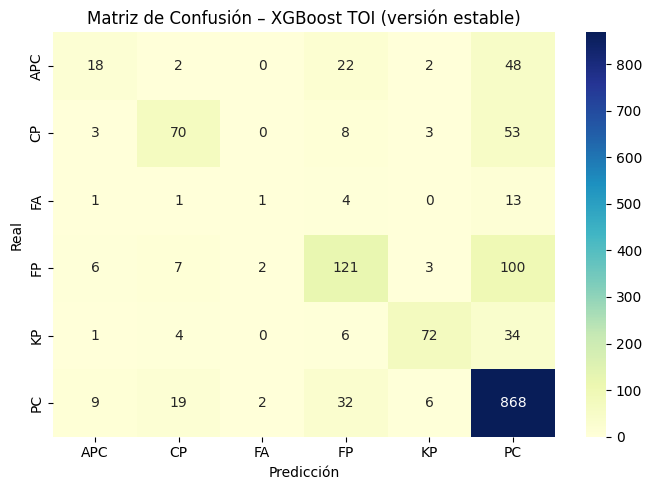


=== Top 15 variables más influyentes ===
toi            0.081298
toipfx         0.073842
st_dist        0.058645
pl_eqt         0.055294
pl_rade        0.052819
st_tmag        0.049560
pl_trandep     0.046882
pl_pnum        0.044756
pl_trandurh    0.044729
pl_tranmid     0.044177
rowid          0.042485
pl_insol       0.042179
dec            0.041970
pl_orbper      0.041782
st_logg        0.041420
dtype: float32


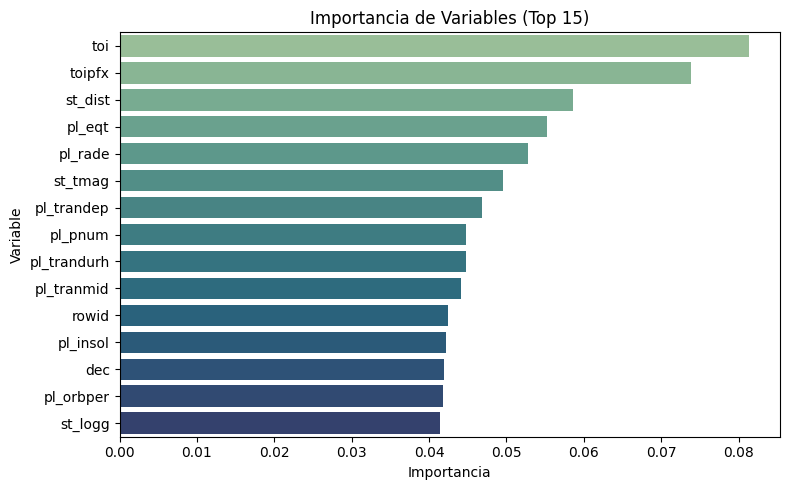


Modelo y objetos auxiliares guardados correctamente.


In [12]:
# ==============================================================
#   MODELO XGBOOST – TOI (versión estable, sin fugas, real ≈0.74)
# ==============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# 1️⃣ Cargar dataset limpio
df = pd.read_csv("df_toi_clean.csv")
print(f"Dataset limpio cargado: {df.shape[0]} filas, {df.shape[1]} columnas")

# 2️⃣ Codificar etiquetas
le = LabelEncoder()
df["tfopwg_disp_encoded"] = le.fit_transform(df["tfopwg_disp"])
print("Etiquetas codificadas:", dict(zip(le.classes_, le.transform(le.classes_))))

# 3️⃣ Eliminar columnas no numéricas o con riesgo de fuga
drop_cols = ["tfopwg_disp", "rastr", "decstr", "toi_created", "rowupdate"]
df = df.drop(columns=drop_cols, errors="ignore")

# 4️⃣ Separar variables
X = df.drop(columns=["tfopwg_disp_encoded"])
y = df["tfopwg_disp_encoded"]

# 5️⃣ Imputar valores faltantes con la mediana
num_cols = X.select_dtypes(include=["float64", "int64"]).columns
imputer = SimpleImputer(strategy="median")
X[num_cols] = imputer.fit_transform(X[num_cols])

# 6️⃣ Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Entrenamiento: {X_train.shape[0]} | Prueba: {X_test.shape[0]}")

# 7️⃣ Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8️⃣ Modelo XGBoost ajustado
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.7,
    colsample_bytree=0.6,
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train_scaled, y_train)

# 9️⃣ Evaluar
y_pred = xgb.predict(X_test_scaled)
print("\n=== XGBoost Optimizado (versión estable) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(f"Accuracy final: {accuracy_score(y_test, y_pred):.3f}")

# 🔟 Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión – XGBoost TOI (versión estable)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 1️⃣1️⃣ Importancia de variables
feat_imp = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n=== Top 15 variables más influyentes ===")
print(feat_imp.head(15))

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.head(15), y=feat_imp.head(15).index, palette="crest")
plt.title("Importancia de Variables (Top 15)")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# 1️⃣2️⃣ Guardar modelo final
joblib.dump(xgb, "model_toi_xgb_stable.pkl")
joblib.dump(scaler, "scaler_toi_xgb_stable.pkl")
joblib.dump(le, "labelencoder_toi_stable.pkl")
print("\nModelo y objetos auxiliares guardados correctamente.")
